In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

In [2]:
# load subject list
sub_list = []
with open('/Users/xinhui.li/Documents/reproducibility/reproducibility/review/hbn/low_motion_30.txt') as f:
    lines = f.readlines()

for line in lines:
    line.strip('\n')
    line.strip('sub-')
    sub_list.append(line[4:11])

sub_list.sort()

In [3]:
# load subject age info
n_sub = 29
df = pd.read_csv("/Users/xinhui.li/Documents/reproducibility/reproducibility/review/hbn/pheno_mri.csv")
age = np.zeros(n_sub)
sex = np.zeros(n_sub)
for i in range(n_sub):
    ind = df.index[df['Rand_ID']==int(sub_list[i])].tolist()[0]
    age[i] = df.loc[ind]["Age_at_Scan"]
    if df.loc[ind]["sex"] == 'M':
        sex[i] = 0
    else:
        sex[i] = 1

print(f"Age range: {min(age):.3f}-{max(age):.3f}; mean: {np.mean(age):.3f}; std: {np.std(age):.3f}")
print(f"Sex number of females: {int(np.sum(sex))}; number of males: {int(n_sub-np.sum(sex))}")

Age range: 10.022-20.489; mean: 16.048; std: 2.417
Sex number of females: 11; number of males: 18


In [4]:
dir="/Users/xinhui.li/Documents/reproducibility/LA/Reproducibility_Analysis/ROI/ROI_Schaefer200"
pipe_list=["hbn_cpac_abcd", "hbn_cpac_ccs", "hbn_cpac_default", "hbn_cpac_fmriprep"]
pearson_corr_all_list = []
pearson_corr_tri_all_list = []
pearson_corr_tri_pca_all_list = []
pearson_corr_gc_list = []
pearson_corr_avgdeg_list = []

# load ROI and calculate correlation
for i, pipe in enumerate(pipe_list):
    pearson_corr_list, pearson_corr_tri_list = [], []
    roi_list = []
    for sub in sub_list:
        sub_path=os.path.join(dir, pipe, f"sub-{sub}_ses-1.1D")
        roi=np.genfromtxt(sub_path).T
        roi_list.append(np.mean(roi, axis=1))
        corr = np.corrcoef(roi)
        pearson_corr_list.append(corr)
        pearson_corr_tri_list.append(corr[np.triu_indices(200,1)])
    pearson_corr = np.array(pearson_corr_list) # 29x200x200
    pearson_corr_tri = np.array(pearson_corr_tri_list)
    pearson_corr_avgdeg_list.append( np.mean(pearson_corr, axis=1) )
    pearson_corr_gc_list.append( np.mean(pearson_corr.reshape([pearson_corr.shape[0],200*200]), axis=1) )
    pearson_corr_all_list.append(pearson_corr)
    pearson_corr_tri_all_list.append(pearson_corr_tri)

    pca = PCA(n_components=20)
    pca_result = pca.fit_transform(pearson_corr_tri_all_list[i])
    pearson_corr_tri_pca_all_list.append(pca_result)

In [5]:
y_pred_age = np.zeros((n_sub, len(pipe_list)))
me = np.zeros((n_sub, len(pipe_list)))
mae = np.zeros((n_sub, len(pipe_list)))

for j in range(len(pipe_list)):
    for i in range(n_sub):
        clf = Ridge(alpha=1.0)
        X_train = np.delete(pearson_corr_tri_all_list[j], i, 0)
        X_test = np.expand_dims(pearson_corr_tri_all_list[j][i,:], axis=0)
        y_train = np.delete(age, i)
        y_test = age[i]
        clf.fit(X_train, y_train)
        y_pred_age[i,j] = clf.predict(X_test)[0]
        me[i,j] = y_test-y_pred_age[i,j]
        mae[i,j] = np.abs(me[i,j])

In [6]:
print("within-pipeline")
within_pipe_mae_mean=np.mean(mae,0)
within_pipe_mae_std=np.std(mae,0)
for i in range(4):
    print(f"pipeline: {pipe_list[i]}; mean: {within_pipe_mae_mean[i]:.3f}; std: {within_pipe_mae_std[i]:.3f}")

print(f"\nbetween-pipeline")
between_pipe_mae_mean = np.zeros(6)
between_pipe_mae_std = np.zeros(6)
count = 0
for i in range(4):
    for j in range(i+1,4):
        between_pipe_mae_mean[count] = np.mean(np.abs(y_pred_age[:,i]-y_pred_age[:,j]))
        between_pipe_mae_std[count] = np.std(np.abs(y_pred_age[:,i]-y_pred_age[:,j]))
        print(f"pipeline pair: {pipe_list[i]} vs {pipe_list[j]}; mean: {between_pipe_mae_mean[count]:.3f}; std: {between_pipe_mae_std[count]:.3f}")
        count = count + 1

print(f"\nratio: {np.mean(between_pipe_mae_mean)/np.mean(within_pipe_mae_mean):.3f}")

within-pipeline
pipeline: hbn_cpac_abcd; mean: 2.082; std: 1.345
pipeline: hbn_cpac_ccs; mean: 1.909; std: 1.247
pipeline: hbn_cpac_default; mean: 1.888; std: 1.232
pipeline: hbn_cpac_fmriprep; mean: 2.089; std: 1.263

between-pipeline
pipeline pair: hbn_cpac_abcd vs hbn_cpac_ccs; mean: 0.378; std: 0.291
pipeline pair: hbn_cpac_abcd vs hbn_cpac_default; mean: 0.397; std: 0.274
pipeline pair: hbn_cpac_abcd vs hbn_cpac_fmriprep; mean: 0.404; std: 0.296
pipeline pair: hbn_cpac_ccs vs hbn_cpac_default; mean: 0.311; std: 0.205
pipeline pair: hbn_cpac_ccs vs hbn_cpac_fmriprep; mean: 0.323; std: 0.294
pipeline pair: hbn_cpac_default vs hbn_cpac_fmriprep; mean: 0.380; std: 0.260

ratio: 0.184


In [7]:
print("within-pipeline")
within_pipe_me_mean=np.mean(me,0)
within_pipe_me_std=np.std(me,0)
for i in range(4):
    print(f"pipeline: {pipe_list[i]}; mean: {within_pipe_me_mean[i]:.3f}; std: {within_pipe_me_std[i]:.3f}")

print(f"\nbetween-pipeline")
between_pipe_me_mean = np.zeros(6)
between_pipe_me_std = np.zeros(6)
count = 0
for i in range(4):
    for j in range(i+1,4):
        between_pipe_me_mean[count] = round(np.mean(y_pred_age[:,i]-y_pred_age[:,j]),3)
        between_pipe_me_std[count] = round(np.std(y_pred_age[:,i]-y_pred_age[:,j]),3)
        print(f"pipeline pair: {pipe_list[i]} vs {pipe_list[j]}; mean: {between_pipe_me_mean[count]:.3f}; std: {between_pipe_me_std[count]:.3f}")
        count = count + 1

print(f"\nratio: {np.mean(between_pipe_me_mean)/np.mean(within_pipe_me_mean):.3f}")

within-pipeline
pipeline: hbn_cpac_abcd; mean: 0.128; std: 2.475
pipeline: hbn_cpac_ccs; mean: 0.062; std: 2.280
pipeline: hbn_cpac_default; mean: 0.086; std: 2.253
pipeline: hbn_cpac_fmriprep; mean: 0.092; std: 2.439

between-pipeline
pipeline pair: hbn_cpac_abcd vs hbn_cpac_ccs; mean: -0.066; std: 0.473
pipeline pair: hbn_cpac_abcd vs hbn_cpac_default; mean: -0.042; std: 0.480
pipeline pair: hbn_cpac_abcd vs hbn_cpac_fmriprep; mean: -0.036; std: 0.500
pipeline pair: hbn_cpac_ccs vs hbn_cpac_default; mean: 0.023; std: 0.371
pipeline pair: hbn_cpac_ccs vs hbn_cpac_fmriprep; mean: 0.029; std: 0.435
pipeline pair: hbn_cpac_default vs hbn_cpac_fmriprep; mean: 0.006; std: 0.461

ratio: -0.156


In [8]:
y_pred_sex_pca = np.zeros((n_sub, len(pipe_list)))
err = np.zeros((n_sub, len(pipe_list)))

for j in range(len(pipe_list)):
    for i in range(n_sub):
        clf = SVC(kernel='linear')
        X_train = np.delete(pearson_corr_tri_pca_all_list[j], i, 0)
        X_test = np.expand_dims(pearson_corr_tri_pca_all_list[j][i,:], axis=0)
        y_train = np.delete(sex, i)
        y_test = sex[i]
        clf.fit(X_train, y_train)
        y_pred_sex_pca[i,j] = clf.predict(X_test)[0]
        err[i,j] = np.abs(y_test-y_pred_sex_pca[i,j])

In [9]:
print("PCA")
print("within-pipeline")
f1 = np.zeros(4)
within_pipe_acc_mean = np.zeros(4)
within_pipe_acc_std = np.zeros(4)
for i in range(4):
    f1[i] = f1_score(sex, y_pred_sex_pca[:,i])
    acc = 1 - np.abs(sex-y_pred_sex_pca[:,i])
    within_pipe_acc_mean[i] = np.mean(acc)
    within_pipe_acc_std[i] = np.std(acc)
    print(f"pipeline: {pipe_list[i]}; F1 score: {f1[i]:.3f}; accuracy mean: {within_pipe_acc_mean[i]:.3f}; accuracy std: {within_pipe_acc_std[i]:.3f}")

print(f"\nbetween-pipeline")
between_pipe_acc_mean = np.zeros(6)
between_pipe_acc_std = np.zeros(6)
count = 0
for i in range(4):
    for j in range(i+1,4):
        acc = 1-np.abs(y_pred_sex_pca[:,i]-y_pred_sex_pca[:,j])
        between_pipe_acc_mean[count] = np.mean(acc)
        between_pipe_acc_std[count] = np.std(acc)
        print(f"pipeline pair: {pipe_list[i]} vs {pipe_list[j]}; consistency mean: {between_pipe_acc_mean[count]:.3f}; consistency std: {between_pipe_acc_std[count]:.3f}")
        count = count + 1

print(f"\nratio: {np.mean(between_pipe_acc_mean)/np.mean(within_pipe_acc_mean):.3f}")

PCA
within-pipeline
pipeline: hbn_cpac_abcd; F1 score: 0.286; accuracy mean: 0.483; accuracy std: 0.500
pipeline: hbn_cpac_ccs; F1 score: 0.522; accuracy mean: 0.621; accuracy std: 0.485
pipeline: hbn_cpac_default; F1 score: 0.364; accuracy mean: 0.517; accuracy std: 0.500
pipeline: hbn_cpac_fmriprep; F1 score: 0.545; accuracy mean: 0.655; accuracy std: 0.475

between-pipeline
pipeline pair: hbn_cpac_abcd vs hbn_cpac_ccs; consistency mean: 0.793; consistency std: 0.405
pipeline pair: hbn_cpac_abcd vs hbn_cpac_default; consistency mean: 0.897; consistency std: 0.305
pipeline pair: hbn_cpac_abcd vs hbn_cpac_fmriprep; consistency mean: 0.759; consistency std: 0.428
pipeline pair: hbn_cpac_ccs vs hbn_cpac_default; consistency mean: 0.897; consistency std: 0.305
pipeline pair: hbn_cpac_ccs vs hbn_cpac_fmriprep; consistency mean: 0.759; consistency std: 0.428
pipeline pair: hbn_cpac_default vs hbn_cpac_fmriprep; consistency mean: 0.793; consistency std: 0.405

ratio: 1.434


In [10]:
print("The maximum differences of predicted ages across pipelines are greater than 0.5 year" \
    f"for {np.sum(np.abs(np.max(y_pred_age,1)-np.min(y_pred_age,1))>0.5)} subjects," \
    f"and greater than 1 year for {np.sum(np.abs(np.max(y_pred_age,1)-np.min(y_pred_age,1))>1)} subjects.")

The maximum differences of predicted ages across pipelines are greater than 0.5 yearfor 18 subjects,and greater than 1 year for 3 subjects.


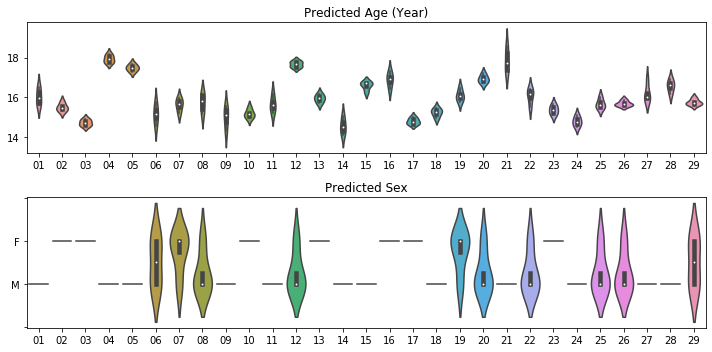

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10,5))

rotation_angle = 0
sub_list = []
for i in range(29):
    sub_id = f'{i+1}'
    sub_id = sub_id.zfill(2)
    sub_list.append(f'{sub_id}')

sns.violinplot(data = y_pred_age.T, ax=axes[0])
axes[0].set_title('Predicted Age (Year)')
axes[0].set_xticklabels(sub_list,rotation=rotation_angle)

sns.violinplot(data = y_pred_sex_pca.T, ax=axes[1])
axes[1].set_title('Predicted Sex')
axes[1].set_xticklabels(sub_list,rotation=rotation_angle)
axes[1].set_yticklabels(['', '', 'M', 'F', ''])

plt.tight_layout()
plt.savefig("/Users/xinhui.li/Documents/reproducibility/reproducibility/review/age/age_sex_pca_pred.png", dpi=300)